# Autoencoders

In [ ]:
import pickle, gzip, math, os, time, shutil, torch, matplotlib as mpl, numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from pathlib import Path
from torch import tensor
from fastcore.test import test_close
import deeplake
import torchvision.transforms.functional as  TF
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

from torch.utils.data import default_collate
from collections import Counter
from typing import Mapping
from operator import itemgetter
from datasets import load_dataset, load_dataset_builder

from minai.training import *
from minai.datasets import * 
from minai.conv import *

torch.manual_seed(42)

mpl.rcParams['image.cmap'] = 'gray'
torch.set_printoptions(precision=2, linewidth=125, sci_mode=False)
np.set_printoptions(precision=2, linewidth=125)

import logging
logging.disable(logging.WARNING)

/Users/anubhavmaity/mambaforge/envs/fastai/lib/python3.9/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (3.8.19) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


## Data

In [ ]:
x, y = 'image', 'label'
name = 'anubhavmaity/notMNIST'
dsd = load_dataset(name, ignore_verifications=True)

/Users/anubhavmaity/mambaforge/envs/fastai/lib/python3.9/site-packages/datasets/load.py:2491: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=no_checks' instead.
  warnings.warn(


In [ ]:
@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

In [ ]:
bs = 256
tds = dsd.with_transform(transformi)

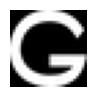

In [ ]:
ds = tds['train']
img = ds[0]['image']
show_image(img, figsize=(1, 1));

In [ ]:
ds

Dataset({
    features: ['image', 'label'],
    num_rows: 14979
})

In [ ]:
collate_dict

<function minai.datasets.collate_dict(ds)>

In [ ]:
cf = collate_dict(ds)

In [ ]:
def collate_(b): return to_device(cf(b))
def data_loaders(dsd, bs, **kwargs): return {k: DataLoader(v, bs, **kwargs) for k, v in dsd.items()}

In [ ]:
dls = data_loaders(tds, bs, num_workers=4, collate_fn=collate_)

In [ ]:
dt = dls['train']
dv = dls['test']

xb, yb = next(iter(dt))

In [ ]:
labels = ds.features[y].names
lbl_getter = itemgetter(*yb[:16])
titles = lbl_getter(labels)

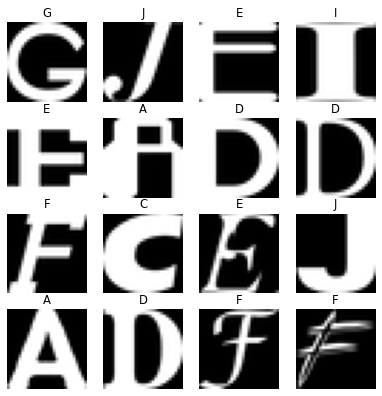

In [ ]:
mpl.rcParams['figure.dpi'] = 70
show_images(xb[:16], imsize=1.7, titles=titles)

## Warmup - classify

In [ ]:
from torch import optim

bs = 256
lr = 0.4

In [ ]:
cnn = nn.Sequential(
    conv(1, 4), # 14x14
    conv(4, 8), # 7x7
    conv(8, 16), # 4x4
    conv(16, 16),  # 2x2
    conv(16, 10, act=False),
    nn.Flatten()
).to(def_device)

In [ ]:
opt = optim.SGD(cnn.parameters(), lr=lr)
loss, acc = fit(5, cnn, F.cross_entropy, opt, dt, dv)

0 2.0415356608672197 0.2437917221650899
1 0.8829927087466771 0.7206942579774894
2 0.44170516919548586 0.8731642196748222
3 0.3736795489874001 0.8881174899070698
4 0.3364278436184566 0.9014686249286056


## Autoencoder

In [ ]:
def deconv(ni, nf, ks=3, act=True):
    layers = [nn.UpsamplingNearest2d(scale_factor=2),
              nn.Conv2d(ni, nf, stride=1, kernel_size=ks, padding=ks//2)]
    if act: layers.append(nn.ReLU())
    return nn.Sequential(*layers)

In [ ]:
def eval(model, loss_func, valid_dl, epoch=0):
    model.eval()
    with torch.no_grad():
        tot_loss, count = 0., 0.
        for xb,_ in valid_dl:
            pred = model(xb)
            n = len(xb)
            count += n
            tot_loss += loss_func(pred, xb).item() * n
    print(epoch, f'{tot_loss/count: .3f}')

In [ ]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, _ in train_dl:
            loss = loss_func(model(xb), xb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        eval(model, loss_func, valid_dl, epoch)

In [ ]:
ae = nn.Sequential( # 28x28
    nn.ZeroPad2d(2), # 32x32
    conv(1, 2), # 16x16
    conv(2, 4), # 8x8
    conv(4, 8), # 4x4
    deconv(8, 4), # 8x8
    deconv(4, 2), # 16x16
    deconv(2, 1, act=False), # 32x32
    nn.ZeroPad2d(-2), # 28x28
    nn.Sigmoid()
).to(def_device)

In [ ]:
ae(xb).shape == xb.shape

True

In [ ]:
eval(ae, F.mse_loss, dv)

0  0.219


In [ ]:
opt = optim.AdamW(ae.parameters(), lr=0.01)
fit(5, ae, F.mse_loss, opt, dt, dv)

0  0.210
1  0.210
2  0.210
3  0.210
4  0.210


In [ ]:
opt = optim.AdamW(ae.parameters(), lr=0.01)
fit(5, ae, F.mse_loss, opt, dt, dv)

0  0.210
1  0.210
2  0.210
3  0.210
4  0.210


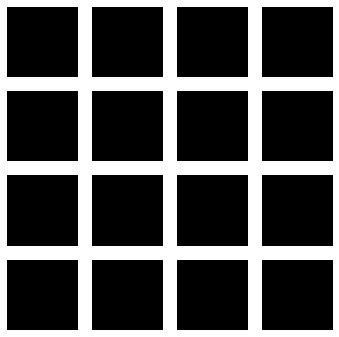

In [ ]:
p = ae(xb)
show_images(p[:16].data.cpu(), imsize=1.5)

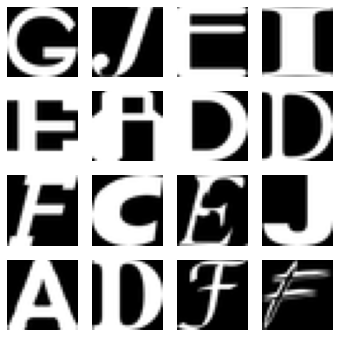

In [ ]:
show_images(xb[:16].data.cpu(), imsize=1.5)

## Export

In [ ]:
from nbdev import nbdev_export; nbdev_export()